In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../0.data-download/scripts/")
from data_loader import load_data, load_train_test_data

In [2]:
# data path
data_directory = "../0.data-download/data/"

In [3]:
# load the training data
dfs_test, dfs, data = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=False
)

In [4]:
# set a unique dataframe that can be appended from
training_df_age = dfs

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_effect_df = pd.DataFrame()
ped_effect_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult effect dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_effect_df = adult_effect_df._append(training_df_age)
        adult_effect_df = adult_effect_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_effect_df = ped_effect_df._append(training_df_age)
        ped_effect_df = ped_effect_df.reset_index(drop=True)

In [6]:
# set a unique dataframe that can be appended from
training_df_sex = dfs

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_effect_df = pd.DataFrame()
female_effect_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male effect dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_effect_df = male_effect_df._append(training_df_sex)
        male_effect_df = male_effect_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female effect dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_effect_df = female_effect_df._append(training_df_sex)
        female_effect_df = female_effect_df.reset_index(drop=True)

In [6]:
print(adult_effect_df.shape)
adult_effect_df.head(3)

(116, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000435,0.127120,-0.158781,0.032833,0.174016,-0.446554,0.072724,0.218064,-0.126822,-0.152098,...,-0.541746,0.098139,0.122490,-0.077374,-0.110560,-0.182248,0.151294,-0.340655,-0.602892,Adult_Female
1,ACH-000356,0.106652,-0.159892,0.109261,0.106453,-0.134623,-0.069101,0.114412,-0.387433,0.079746,...,-0.590345,-0.021920,-0.066912,0.051635,-0.206775,-0.396002,0.132128,-0.180380,-0.260363,Adult_Female
2,ACH-001418,-0.000254,-0.016919,0.011651,0.150072,-0.225204,0.029442,0.061401,-0.176111,0.031987,...,-0.182437,0.120437,-0.042140,-0.055339,0.092032,-0.118331,0.008183,-0.214735,-0.407606,Adult_Female


In [7]:
print(ped_effect_df.shape)
ped_effect_df.head(3)

(21, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-001618,-0.067818,-0.227855,0.019062,-0.064588,-0.108135,0.063899,0.416703,0.051042,-0.058059,...,-0.132810,-0.128365,-0.031623,-0.029547,0.108570,-0.425476,-0.141151,-0.219427,-0.020476,Adult_Unknown
1,ACH-000782,0.003626,0.011273,0.047244,0.042954,-0.044646,-0.040099,0.201341,0.091778,0.073563,...,-0.451573,0.163216,0.178096,0.110522,-0.008329,-0.282517,0.036653,-0.084539,-0.235935,Pediatric_Female
2,ACH-001548,0.030793,-0.121040,-0.009295,0.251490,-0.253975,-0.085377,0.059923,-0.199859,0.124358,...,-0.454113,0.100711,0.033788,0.012192,-0.051594,-0.147699,0.098227,-0.146901,-0.626482,Pediatric_Female


In [7]:
print(male_effect_df.shape)
male_effect_df.head(3)

(77, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000424,-0.019564,-0.033171,0.096790,0.189534,-0.106040,-0.133097,0.031001,-0.280690,0.197665,...,-0.112876,0.071519,0.044086,-0.074970,0.013155,-0.097721,0.001975,-0.089875,-0.219496,Adult_Male
1,ACH-000510,0.001227,-0.005976,0.011694,0.079630,-0.070977,0.059904,0.039370,-0.192833,-0.032210,...,-0.200556,0.007017,0.155182,0.044714,-0.152854,-0.123519,-0.028177,-0.014255,-0.355884,Adult_Male
2,ACH-000216,-0.035347,0.030233,0.121844,0.130710,-0.298670,-0.289791,0.059666,-0.160183,-0.002669,...,-0.485305,0.021714,0.075695,-0.167708,-0.047056,-0.206607,-0.069380,-0.009310,-0.357912,Adult_Male


In [8]:
print(female_effect_df.shape)
female_effect_df.head(3)

(58, 17204)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-001145,-0.113724,-0.204584,0.159299,0.061113,-0.057733,0.048251,-0.067589,-0.119802,0.046334,...,-0.214615,0.120907,0.152069,0.160187,-0.031819,-0.222290,-0.044924,-0.097959,-0.568342,Adult_Female
1,ACH-001151,-0.083828,-0.051462,0.018874,0.071211,-0.214500,-0.062853,0.090913,-0.359436,0.065931,...,-0.444820,-0.005479,0.176285,-0.023844,-0.077274,-0.201053,-0.116192,-0.125549,-0.463819,Adult_Female
2,ACH-000915,-0.054460,-0.013625,0.019582,0.207911,-0.402061,-0.007346,-0.071771,-0.149859,0.136915,...,-0.858638,0.070577,0.073084,-0.093967,-0.052186,0.034728,0.018185,-0.287422,-0.260291,Adult_Female


In [9]:
# drop the string values from all dataframes
adult_effect_df_float = adult_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)
ped_effect_df_float = ped_effect_df.drop(columns=["ModelID", "age_and_sex"])

male_effect_df_float = male_effect_df.drop(columns=["ModelID", "age_and_sex"])
female_effect_df_float = female_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)

effect_df = dfs.drop(columns="age_and_sex")
effect_df = effect_df.set_index("ModelID")

In [10]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_effect_df_float, ped_effect_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(17202, 2)


,t_stat,p_value
0,-0.242461,0.808791
1,-0.796788,0.426973
2,0.318236,0.750798


In [11]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_effect_df_float, female_effect_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(17202, 2)


,t_stat,p_value
0,1.031475,0.304190
1,0.487729,0.626545
2,1.181051,0.239690


In [12]:
print(effect_df.shape)
effect_df.head(3)

(137, 17202)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000070,0.019970,-0.057256,0.070187,0.261183,-0.226158,0.032391,0.074601,0.006518,0.054415,0.143882,...,-0.287427,-0.276654,0.101140,0.259753,-0.068660,-0.154482,-0.057477,-0.161584,-0.118518,-0.346338
ACH-000424,-0.019564,-0.033171,0.096790,0.189534,-0.106040,-0.133097,0.031001,-0.280690,0.197665,0.141716,...,-0.286677,-0.112876,0.071519,0.044086,-0.074970,0.013155,-0.097721,0.001975,-0.089875,-0.219496
ACH-000510,0.001227,-0.005976,0.011694,0.079630,-0.070977,0.059904,0.039370,-0.192833,-0.032210,0.055966,...,-0.186052,-0.200556,0.007017,0.155182,0.044714,-0.152854,-0.123519,-0.028177,-0.014255,-0.355884


In [14]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = effect_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(17202, 2)


,gene_ID,variance
0,A1BG (1),0.009896
1,A1CF (29974),0.009441
2,A2M (2),0.010807


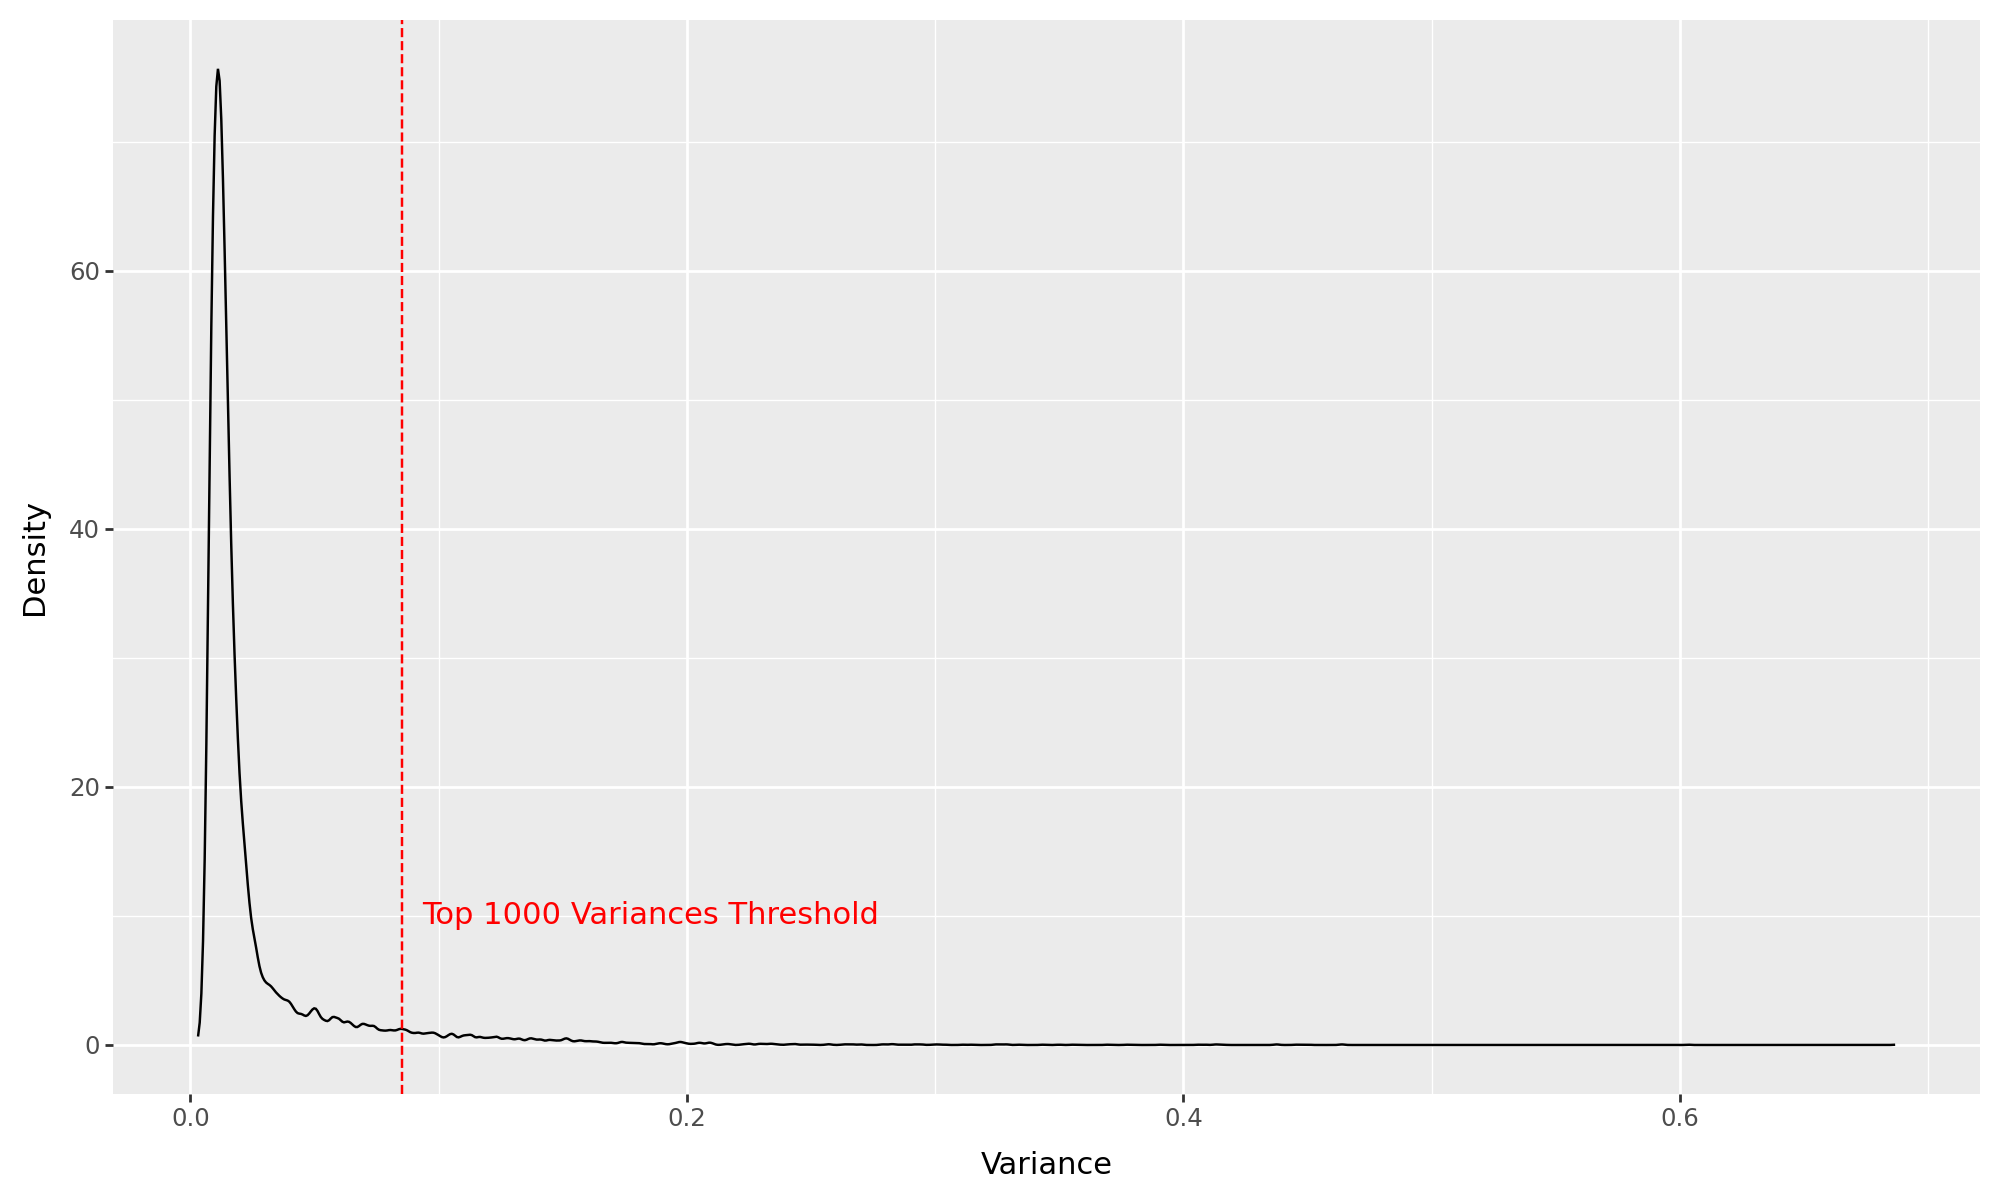

In [24]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
from plotnine import annotate


n = variance_df["variance"].nlargest(1000)
variance_threshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_threshold, linetype="dashed", color="red")
    + annotate(geom="text", x=variance_threshold + 0.1, y = 10, label="Top 1000 Variances Threshold", color="red")
    + p9.theme(figure_size=(10, 6))
    + p9.xlab("Variance")
    + p9.ylab("Density")
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [25]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .csv
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.csv"
)
df.to_csv(testing_df_output, index=False)
print(df.shape)
df.head(3)

(17202, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.009896,-0.242461,1.031475
1,A1CF (29974),0.009441,-0.796788,0.487729
2,A2M (2),0.010807,0.318236,1.181051


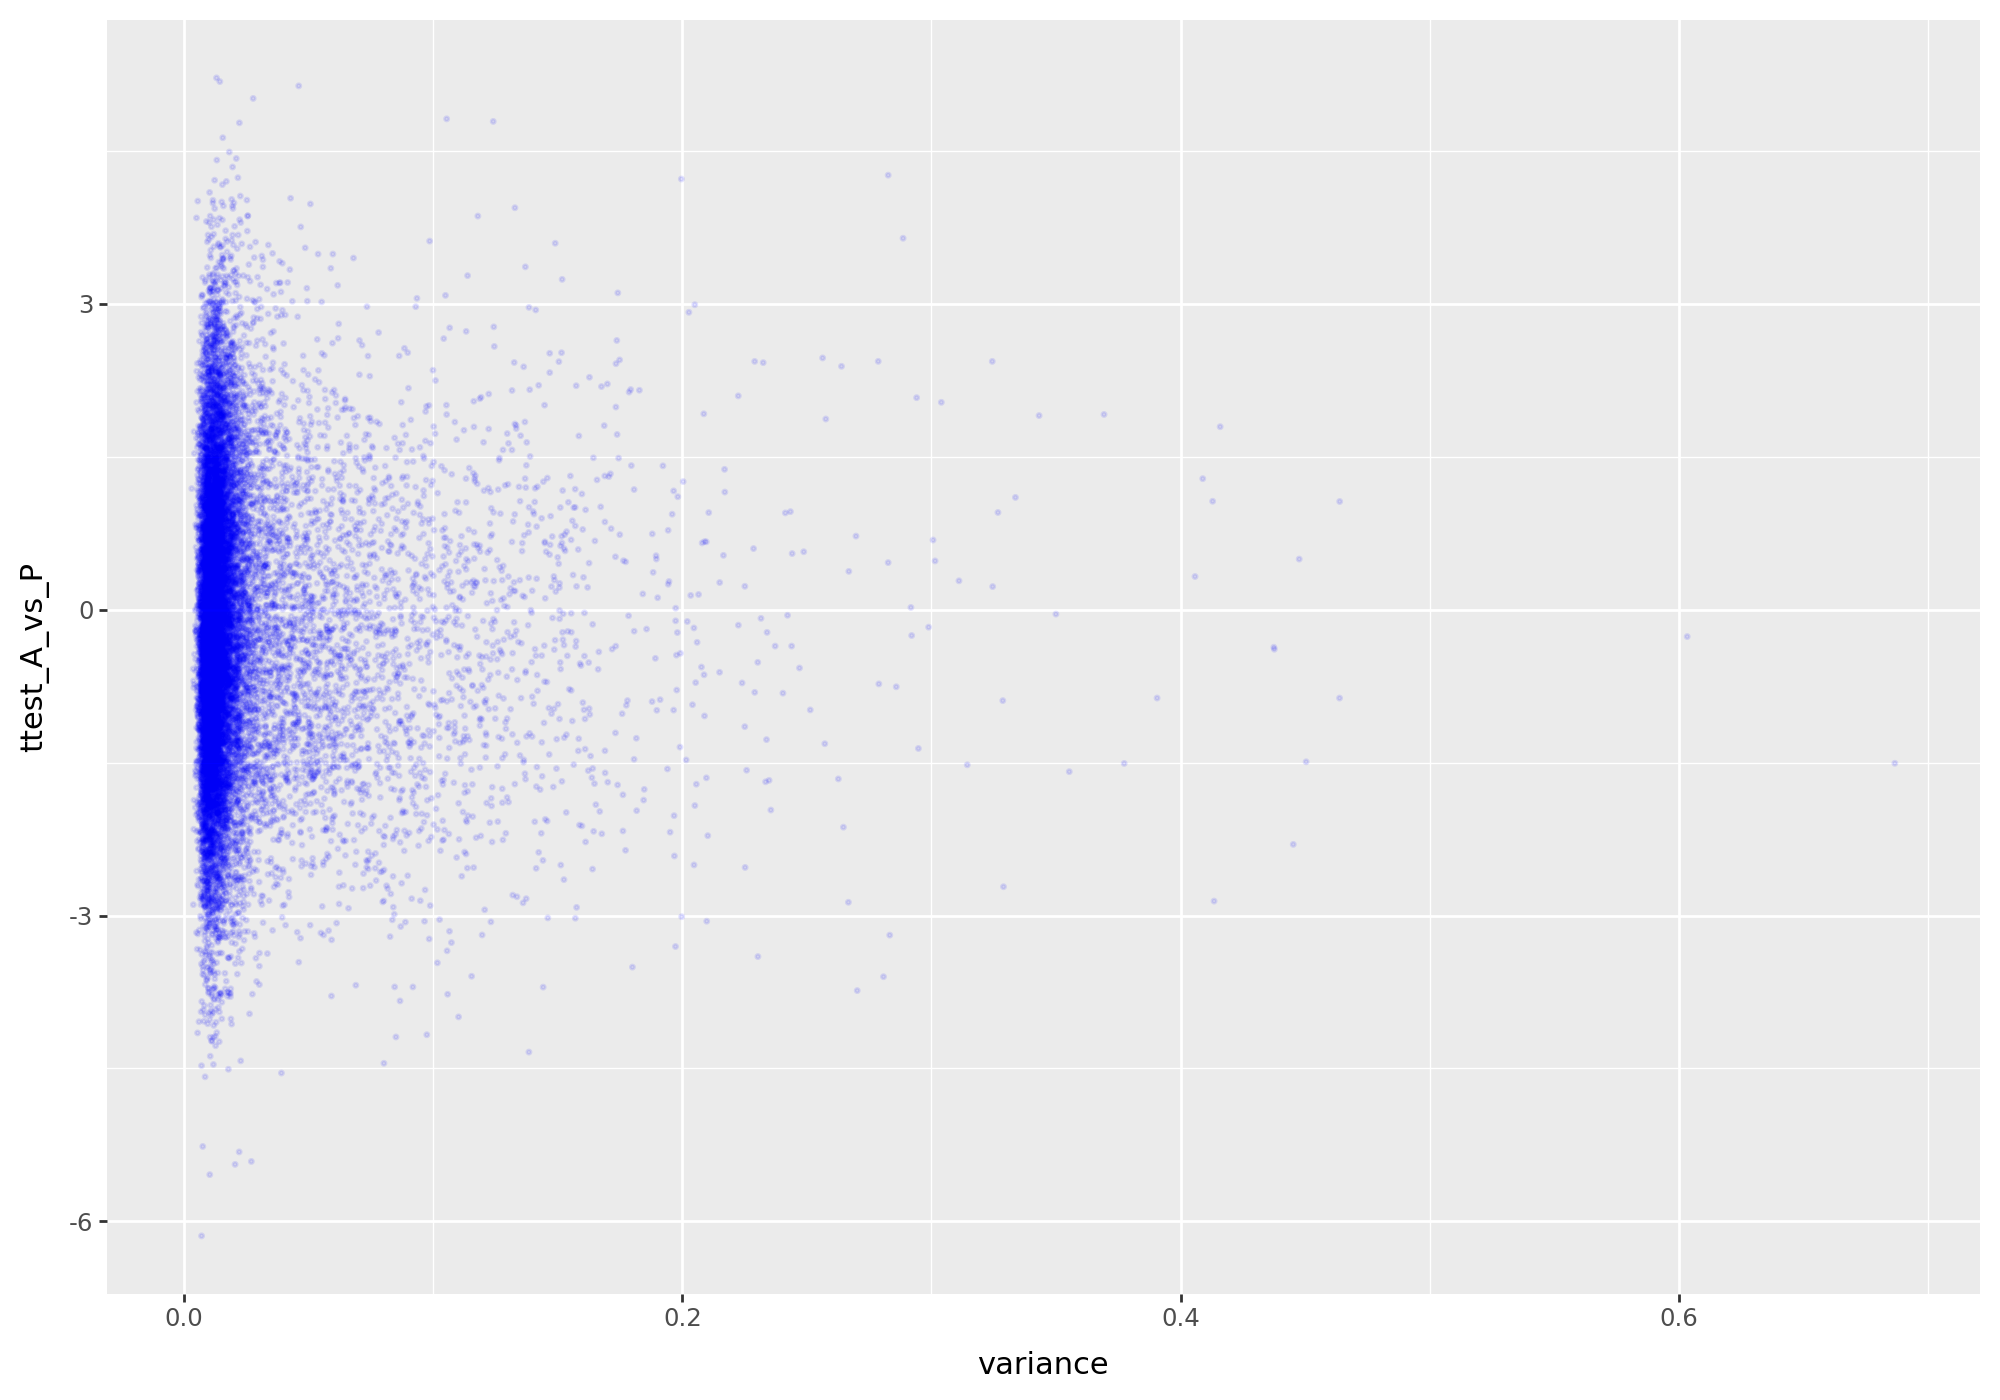

In [26]:
# plot adult-pediatric ttest versus variance
#but why tho what 
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

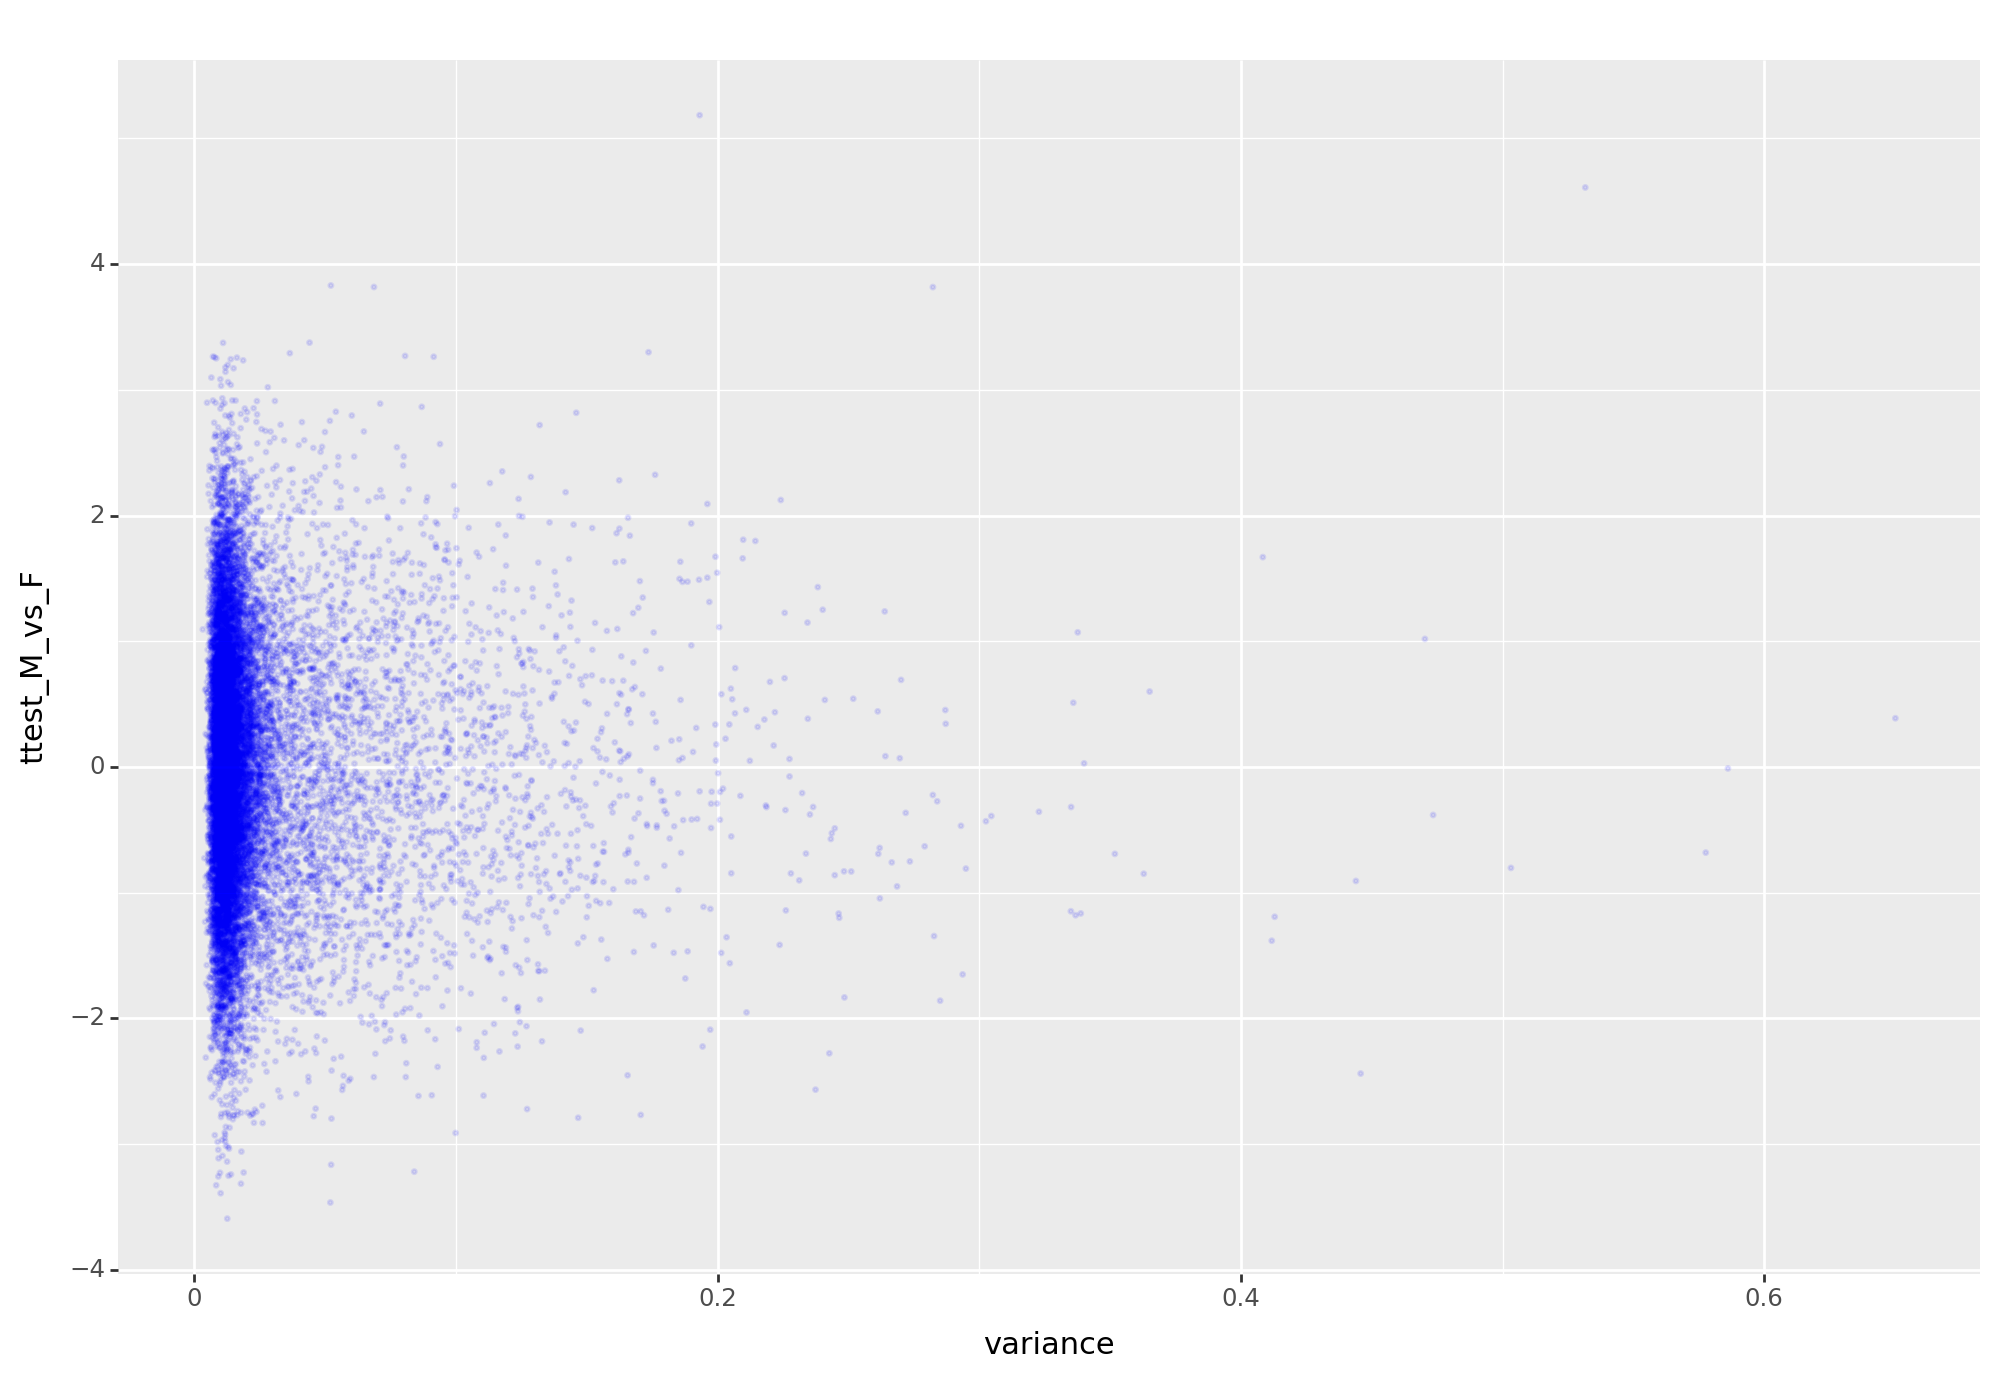

<Figure Size: (1000 x 700)>

In [18]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot